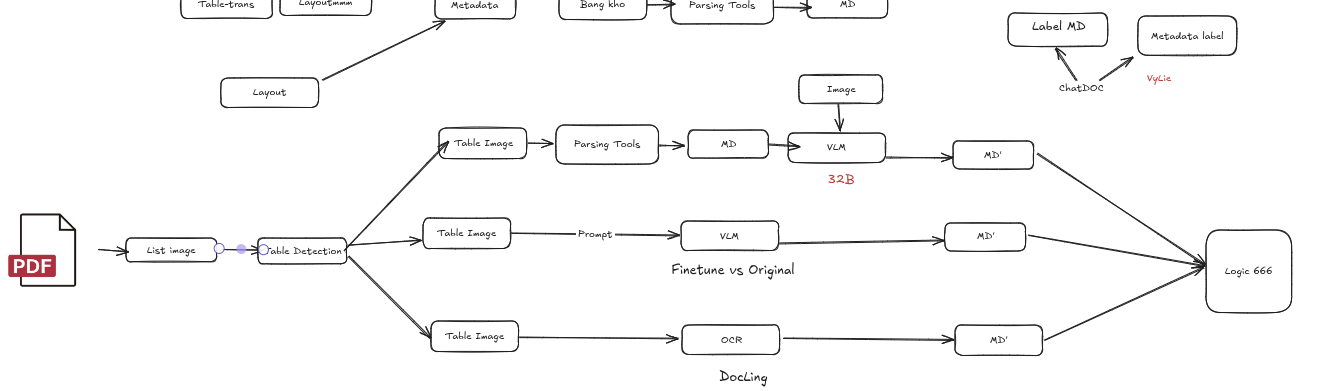

In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


c:\Users\Admin\Data\WDM-AI-TEMIS


In [2]:
from configs.config import *
from libs.common import *
from utils.mongodb_connection import *
from utils.rag_utils_mongodb import *
from utils.format_utils import *
import json
load_dotenv(find_dotenv())

c:/Users/Admin/Data/WDM-AI-TEMIS


c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-04 04:51:28.724 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


True

### VLM-LLM Base Enrich approach

### Openroute

#### Summarize

In [3]:
summary_text = """
This image contains a data table or a keyboard shortcut matrix. Please analyze and describe it thoroughly based on the following instructions:

#### Table Structure:
- **How many rows and columns are there?**
  - Provide the total number of rows and columns in the table.
  
- **What are the headers of each column?**
  - List the names or labels of each column header.

- **Is there a total row, footer, or any notes?**
  - Indicate if there is a summary row (e.g., total), footer, or additional notes at the bottom of the table.

#### Data Overview:
- **List the data row by row if possible.**
  - Present the data in each row, ideally in a structured format.

- **Explain the meaning of each value in the table cells.**
  - Describe what each value represents (e.g., numerical data, categorical data, etc.).

- **Clarify any special symbols (e.g., %, $, color codes, icons).**
  - Explain the significance of any symbols, icons, or formatting used in the table.

#### In-depth Analysis:
- **Which rows or columns stand out as significant?**
  - Identify rows or columns that contain important information or trends.

- **Are there any relationships, patterns, or correlations between columns?**
  - Analyze whether certain columns are related or show dependencies.

- **Identify any upward/downward trends.**
  - Highlight any noticeable trends in the data over time or across categories.

- **Point out any anomalies or outliers in the data.**
  - Note any unusual values or outliers that deviate from the norm.

#### Comparison and Interpretation:
- **Compare values across rows or groups.**
  - Compare data across different rows or groups to identify similarities or differences.

- **Identify the highest and lowest values.**
  - Determine the maximum and minimum values in the dataset.

- **What does the table suggest or imply overall?**
  - Summarize the main insights or conclusions drawn from the table.

#### If the table contains keyboard shortcuts or commands:
- **Describe the action associated with each shortcut key combination.**
  - Explain what each shortcut does (e.g., Ctrl + C for copy).

- **Group the shortcuts by functionality if possible (e.g., navigation, editing, system-level commands).**
  - Organize shortcuts into categories based on their purpose.

#### Presentation:
- **Please present your response in a well-structured and easy-to-read format.**
  - Use bullet points, numbered lists, or tables where appropriate to enhance readability.
"""

In [4]:
extract_context = f"""
You are an advanced vision-language model. Your task is to analyze the provided image and extract any tabular data present in it.

Please follow these instructions carefully:
1. Identify the table(s) in the image.
2. Reproduce the table structure as accurately as possible using Markdown syntax.
3. Ensure that all rows and columns are correctly aligned.
4. Retain all text content exactly as it appears in the image, including numbers, symbols, abbreviations, and special characters.
5. If multiple tables are present, extract each one separately and clearly indicate which table is which.
6. Avoid adding any extra explanation or commentary — only return the Markdown table(s).

Example of expected output:
| Header1 | Header2 | Header3 |
|---------|---------|---------|
| Row1Col1 | Row1Col2 | Row1Col3 |
| Row2Col1 | Row2Col2 | Row2Col3 |

Now, analyze the input image and provide your response below. Please just return the Markdown table(s) without any additional text or explanation.:

"""

In [5]:
def prompt_for_summary(model = "qwen/qwen2.5-vl-32b-instruct:free", base64_image = None, prompt_text= summary_text):
    return json.dumps({
            "model": model,
            "messages": [
            {
                "role": "user",
                "content": [
                {
                    "type": "text",
                    "text": prompt_text
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/png;base64,{base64_image}"
                    }
                }
                ]
            }
            ],
            
        })

In [6]:
def table_extract_context(model = "qwen/qwen2.5-vl-32b-instruct:free", base64_image = None, prompt_text= summary_text):
    return json.dumps({
            "model": model,
            "messages": [
            {
                "role": "user",
                "content": [
                {
                    "type": "text",
                    "text": prompt_text
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/png;base64,{base64_image}"
                    }
                }
                ]
            }
            ],
            
        })

In [7]:
def table_markdown_context(model, base64_image, markdown_content , summary_content):
    return json.dumps({
    "model": model,
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"""
        You are given three sources of information related to a single table:

        1. **Raw Extracted Markdown Table**: This is the output from automated table extraction tools. While it contains all the necessary data, its structure may be incorrect — column headers may be misaligned, rows may not match properly, and formatting can be inconsistent.
        Use this only to reference the raw data values, not the structure. Here is the raw extracted markdown table below:
        {markdown_content}
        2. **Table Summary**:This is a detailed description of the original table’s purpose, layout, and the meaning of each column and row.
        Use this as your primary source to guide the table’s structure. Here is the summary of the table:
        {summary_content}
        3. **Table Image (Visual Shortcut)**: This is a visual representation of the actual table. Use it to validate the layout, verify column headers, row alignments, and relationships between data entries.
        This image acts as your ground truth.
        Here is the image:
        ![Table image]

        ---

        ### Your task:

        Based on these three inputs, reconstruct a **well-formatted Markdown table** with accurate column headers, rows, alignment, and structure. Ensure that:

        - All data points from the raw table are included.
        - Pay special attention to:

        * Merged columns (colspan): If a cell like "ABC" spans across multiple columns (e.g., columns A–C), this is a clear signal to merge columns.
        * Merged rows (rowspan): If a value extends downward across multiple rows, reflect this properly in the Markdown layout.
        - The final structure adheres to the format described in the summary.
        - Ensure the total number of rows and columns matches what is shown in the image and described in the summary.
        - Any inconsistencies are resolved using the image as reference.
        - The output is only the corrected Markdown table and nothing else.

        Return only the fixed and properly structured Markdown table, dont use space or enter char.
        """
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/png;base64,{base64_image}"
                    }
                }
                ]
            }
            ],
            
        })

In [8]:
import time
def VLM_enrichdata(
        url= "https://openrouter.ai/api/v1/chat/completions", 
        key= None,
        summary_context= None, 
        base64_image=None
        ):
    
    headers={
            "Authorization": f"Bearer {key}",
            "Content-Type": "application/json",
        }
    
    summary_content=requests.post(
        url=url,
        headers=headers,
        data= prompt_for_summary(model="qwen/qwen2.5-vl-32b-instruct:free", base64_image=base64_image, prompt_text=summary_context)
        )
    summary_content = summary_content.json().get("choices", [{}])[0].get("message", {}).get("content", "")

    time.sleep(3)  

    markdown_content=requests.post(
        url=url,
        headers=headers,
        data= table_extract_context(model="mistralai/mistral-small-3.1-24b-instruct:free", base64_image=base64_image, prompt_text=extract_context)
        )
    markdown_content = markdown_content.json().get("choices", [{}])[0].get("message", {}).get("content", "")
    time.sleep(3)  


    table_markdown = requests.post(
        url=url,
        headers=headers,
        data= table_markdown_context("mistralai/mistral-small-3.1-24b-instruct:free", base64_image, markdown_content, summary_content)
        )
    
    time.sleep(3)  
    return table_markdown.json().get("choices", [{}])[0].get("message", {}).get("content", "")
    

In [ ]:
def full_pipeline_vlm(source_path, verbose=1):
    """
    Hàm xử lý toàn bộ pipeline với VLM
    """
    image_extensions = ('.png',)
    results = []
    for filename in os.listdir(source_path):
        file_path = os.path.join(source_path, filename)
        key = random.choice([os.getenv('API_OPENROUTE_locdinh'), os.getenv('API_OPENROUTE_pjx'), os.getenv('API_OPENROUTE_ueh'), os.getenv('API_OPENROUTE_dynamic'), os.getenv('API_OPENROUTE_innolab')] )

        if os.path.isfile(file_path) and filename.lower().endswith(image_extensions):
            if verbose >= 1:
                print(f"Đang xử lý ảnh: {filename}")
            try:
                with open(file_path, "rb") as image_file:
                    base64_image = base64.b64encode(image_file.read()).decode("utf-8")
                    table_markdown = VLM_enrichdata(key=key, base64_image=base64_image, summary_context=summary_text)
                result_item = {
                    "image_path": filename,
                    "markdown_content": table_markdown,
                }
                # print(result_item)
                results.append(result_item)
            except Exception as e:
                output_json_path = f'{exps_dir}/vlm_enrich_results.json'
                json_result = json.dumps(results, indent=2, ensure_ascii=False)
                with open(output_json_path, 'w', encoding='utf-8') as json_file:
                        json_file.write(json_result)
                return
    

    return results

In [12]:
output_json_path = f'{exps_dir}/vlm_enrich_results.json'
image_path = f"{data_dir}/cropped_tables_output"
vlm_enrich_results = full_pipeline_vlm(source_path=image_path, verbose=1)
json_result = json.dumps(vlm_enrich_results, indent=2, ensure_ascii=False)
with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json_file.write(json_result)


Đang xử lý ảnh: 021f1855-ef83-42c3-8066-80c615fa74dc.png
{'image_path': '021f1855-ef83-42c3-8066-80c615fa74dc.png', 'markdown_content': ''}
Đang xử lý ảnh: 029bdd3f-cd39-439a-801c-91ec11207a43.png
{'image_path': '029bdd3f-cd39-439a-801c-91ec11207a43.png', 'markdown_content': ''}
Đang xử lý ảnh: 059f228f-016e-44fa-8e3a-be12e2d282b9.png
{'image_path': '059f228f-016e-44fa-8e3a-be12e2d282b9.png', 'markdown_content': ''}
Đang xử lý ảnh: 0683f65e-7404-42dc-8efd-eb99b3c1b733.png


KeyboardInterrupt: 

In [14]:
import requests
import json
import os

response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {os.getenv('API_OPENROUTE_locdinh')}",
    "Content-Type": "application/json",
  },
  data=json.dumps({
    "model": "qwen/qwen2.5-vl-32b-instruct:free",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": """
xin chao
"""
          }
        ]
      }
    ],
    
  })
)
print(response)
print(response.json().get("choices", [{}])[0].get("message", {}).get("content", ""))

<Response [429]>



In [ ]:
json_result = json.dumps(vlm_enrich_results, indent=2, ensure_ascii=False)
with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json_file.write(json_result)
